<a href="https://colab.research.google.com/github/kyw061827/Yewon-KIM/blob/main/GEE_0082_sen2_turbidity_Tajikistan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""GEE_0082_sen2_turbidity_Tajikistan.ipynb

타지키스탄의 물 탁도 매핑 및 모니터링을 위해 수정된 코드입니다.
원본 튜토리얼: Google Earth Engine Tutorial-164: Sentinel-2 Water Turbidity Mapping and Monitoring using Python API (Xee)
"""

import ee
import geemap
import xarray as xr
!pip install xee
import xee

In [2]:
# Google Earth Engine 초기화
# YOUR_GEE_PROJECT_ID를 사용자 본인의 GEE 프로젝트 ID로 변경하세요.
# 예: project = 'ee-my-personal-project'
ee.Authenticate()
ee.Initialize(
    project = 'my-gee-project-tjk-turbidity', # <-- 이 부분을 사용자의 GEE 프로젝트 ID로 변경하세요.
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [3]:
# 🗺️ 타지키스탄의 관심 영역(ROI) 정의
# 타지키스탄의 대략적인 경계 좌표 (Bounding Box)
# [서경, 남위, 동경, 북위]
# 예시 좌표: [67.0, 36.5, 75.0, 41.0]
tajikistan_bbox = [67.0, 36.5, 75.0, 41.0]
roi = ee.Geometry.BBox(*tajikistan_bbox)

In [18]:

# 지도 객체는 필수는 아니지만, ROI를 시각화하기 위해 생성할 수 있습니다.
# map = geemap.Map(center=[38.8, 71.0], zoom=6, basemap='SATELLITE')
# map.add_layer(roi, {'color': 'red'}, 'Tajikistan ROI')
# map

# 💧 물 탁도(Turbidity) 계산 함수 (NDTI 기반)
# 원본 코드 유지
def turbidity(img):
    # 구름 마스킹 (확률 20% 미만)
    cloud = img.select('probability')
    cloud_free = cloud.lt(20)

    # Sentinel-2 표면 반사율 스케일링
    sr = img.select('B.*').multiply(0.0001)

    # NDWI 계산 (B3: 녹색, B8: NIR) - 물 영역 식별
    ndwi = sr.normalizedDifference(['B3','B8']).rename('ndwi')
    water_body = ndwi.gt(0.1) # NDWI 0.1 이상을 물로 간주

    # NDTI 계산 (정규화된 탁도 지수)
    # NDTI = (Red - Green) / (Red + Green) => (B4 - B3) / (B4 + B3)
    ndti = sr.normalizedDifference(['B4','B3']).rename('ndti')

    # 구름 및 물 영역 마스크 적용
    return ndti.updateMask(cloud_free).updateMask(water_body).copyProperties(img, ['system:time_start'])

In [19]:
sen2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .linkCollection(ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY"), 'probability')
    .filterBounds(roi) # 타지키스탄 ROI로 변경
    .filterDate('2025-06-01','2025-11-16') # 날짜 범위 설정
    .map(turbidity) # 탁도 함수 적용
)

In [22]:
# 🖼️ Xee를 사용하여 GEE ImageCollection을 Xarray Dataset으로 변환
# 주의: 이 과정은 데이터 양에 따라 시간이 오래 걸리거나 Colab 메모리 제한을 초과할 수 있습니다.
# 계산 부하를 줄이기 위해 scale을 0.01로 조정합니다. (약 1.1km 해상도)
# 더 높은 해상도를 원하면 scale을 줄여야 하지만, Colab에서 실패할 가능성이 높습니다.
ds = xr.open_dataset(
    sen2,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.05, # 계산 부하를 줄이기 위해 0.01에서 0.05로 조정
    geometry = roi # 타지키스탄 ROI 적용
)


In [23]:
# 시간 순서로 정렬하고 값 조정 (원본 코드 유지)
ds = ds.sortby('time') * 1

In [24]:
# 📅 월별 최대 탁도 값 계산
ds_monthly = ds.resample(time = 'M').max('time')
print(ds_monthly)

/usr/local/lib/python3.12/dist-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 348kB
Dimensions:  (time: 6, lon: 160, lat: 90)
Coordinates:
  * time     (time) datetime64[ns] 48B 2025-06-30 2025-07-31 ... 2025-11-30
  * lon      (lon) float64 1kB 67.03 67.08 67.12 67.17 ... 74.88 74.92 74.97
  * lat      (lat) float64 720B 36.52 36.58 36.62 36.67 ... 40.88 40.92 40.98
Data variables:
    ndti     (time, lon, lat) float32 346kB nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_nam

월별 탁도 맵을 시각화합니다...


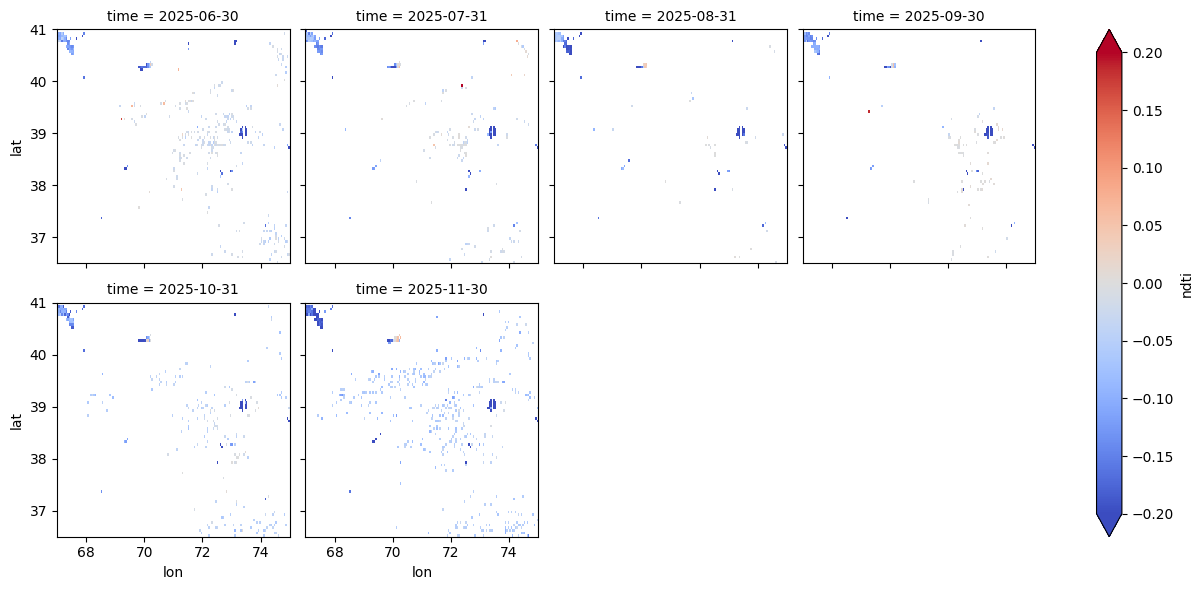

In [25]:
# 📊 월별 탁도 맵 시각화
# Colab 환경에서는 맵의 개수에 따라 시각화에 시간이 걸릴 수 있습니다.
print("월별 탁도 맵을 시각화합니다...")
ds_monthly.ndti.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    robust = True,
    col_wrap = 4, # 열 개수를 4개로 조정
    cmap = 'coolwarm', # 색상표 (차가움: 낮음, 따뜻함: 높음)
    vmax = 0.2 # 탁도 지수 최대값 설정
)


In [ ]:
# 📈 타지키스탄 전체 평균 탁도 시계열 데이터프레임 추출
ds_mean = ds_monthly.mean(dim = ['lat','lon']).to_dataframe()

In [ ]:
# 💾 결과를 CSV 파일로 저장
ds_mean.to_csv('turbidity_tajikistan_monthly_mean.csv')

In [ ]:
print("\n'turbidity_tajikistan_monthly_mean.csv' 파일이 저장되었습니다.")

In [ ]:
print("Normalized Difference Turbidity Index(NDTI):")

In [ ]:
print(ds_mean)